# Submitted By:
### Asad Tariq 19I-0659
### Abdullah Abbasi 19I-2179
### Saim Aslam 19I-0461

In [1]:

import datetime
import time
import pandas as pd
import tensorflow as tf
import json
from pathlib import Path
import re
import random
import inflect
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 61.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 111.3 MB/s eta 0:00:00


In [ ]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel, GPT2Config, AdamW, get_linear_schedule_with_warmup

In [ ]:
import torch
torch.manual_seed(64)
from torch.utils.data import Dataset, random_split, DataLoader, RandomSampler, SequentialSampler
!pip show torch

Name: torch
Version: 2.0.0+cu118
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3
Location: /usr/local/lib/python3.10/dist-packages
Requires: filelock, jinja2, networkx, sympy, triton, typing-extensions
Required-by: fastai, torchaudio, torchdata, torchtext, torchvision, triton


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:

nRowsRead = None # specify 'None' if want to read whole file
#df = pd.read_csv('INPUT/all_haiku.csv', delimiter=',', nrows = nRowsRead)
df=pd.read_csv('/content/gdrive/MyDrive/Work/all_haiku.csv')

In [ ]:

df.dataframeName = 'all_haiku.csv'
nRow, nCol = df.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 144123 rows and 6 columns


In [ ]:
df=df.drop('Unnamed: 0',axis=1)
df=df.drop('source',axis=1)
df=df.drop('hash',axis=1)

In [ ]:
df["2"] = df["2"].astype(str)
df["2"] = [x.replace('-','') for x in df["2"]]
df = df.replace('[^\w\s]', '')
df = df.replace('-','',regex=True)
df.rename(columns = {'0':0,'1':1,'2':2}, inplace = True)

In [ ]:
df.head(20)

,0,1,2
0,fishing boats,colors of,the rainbow
1,ash wednesday,trying to remember,my dream
2,snowy morn,pouring another cup,of black coffee
3,shortest day,flames dance,in the oven
4,haze,half the horse hidden,behind the house
5,low sun,the lady in red,on high heels
6,advent,the passing stranger,farts
7,tarn,a bubble in,the ice
8,snowflakes,new asphalt,in the holes
9,Crystal Night',gusts of rain,outside


In [ ]:
input_list=[]
#for i in range(144123):
for i in range(10000):
    input_list.append(df[0][i]+'\n'+df[1][i]+'\n'+df[2][i]+'.')

In [ ]:
print(input_list[0])

fishing boats
colors of
the rainbow.


In [ ]:
class HaikuDataset(Dataset):
  def __init__(self, haikus, tokenizer, max_length=25, gpt2_type="gpt2"):
    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []

    for haiku in haikus:

      encodings_dict = tokenizer("<|startoftext|>"+haiku+"<|endoftext|>",
                                 truncation=True,
                                 max_length=max_length,
                                 padding="max_length")
      
      self.input_ids.append(torch.tensor(encodings_dict["input_ids"]))
      self.attn_masks.append(torch.tensor(encodings_dict["attention_mask"]))

  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx]

In [ ]:
# Loading GPT2 Tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', 
                                          bos_token='<|startoftext|>', 
                                          eos_token='<|endoftext|>', 
                                          pad_token='<|pad|>')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
print(tokenizer.encode("<|startoftext|> Hello World <|endoftext|>", padding="max_length", max_length=10))
print(len(tokenizer))

[50257, 18435, 2159, 220, 50256, 50258, 50258, 50258, 50258, 50258]
50259


In [ ]:
# Finding length of maximum token in dataset
max_length = max([len(tokenizer.encode(haiku)) for haiku in input_list])
print(max_length)
max_length = 25

500


In [ ]:
x = [len(tokenizer.encode(haiku)) for haiku in input_list if len(tokenizer.encode(haiku)) < 100]

In [ ]:
y = [len(tokenizer.encode(haiku)) - len(haiku.split()) for haiku in input_list]

In [ ]:
print(sum(y)/len(y))

5.7489


98 9950


<function matplotlib.pyplot.show(close=None, block=None)>

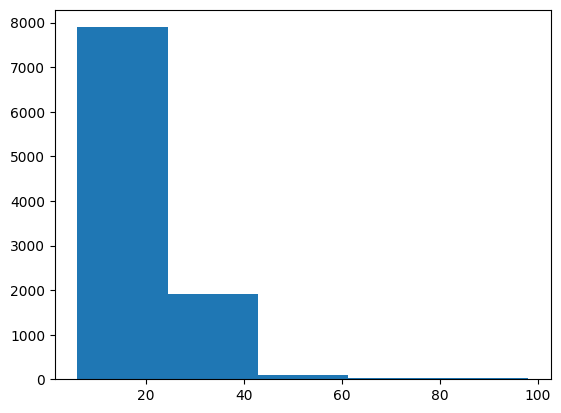

In [ ]:
print(max(x), len(x))
plt.hist(x, bins = 5)
plt.show

In [ ]:
batch_size = 10
max_length = 25

In [ ]:
dataset = HaikuDataset(input_list, tokenizer, max_length=max_length)

# Split data into train and validation sets
train_size = int(0.9*len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
print("Number of samples for training =", train_size)
print("Number of samples for validation =", val_size)

Number of samples for training = 9000
Number of samples for validation = 1000


In [ ]:
train_dataset[0]

(tensor([50257,    64, 14310,   198,  6236,  6448,   319,  4417,   198, 12853,
          8824,    13, 50256, 50258, 50258, 50258, 50258, 50258, 50258, 50258,
         50258, 50258, 50258, 50258, 50258]),
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0]))

In [ ]:
train_dataloader = DataLoader(train_dataset,
                              sampler=RandomSampler(train_dataset),
                              batch_size=batch_size)

val_dataloader = DataLoader(val_dataset,
                            sampler=SequentialSampler(val_dataset),
                            batch_size=batch_size)

In [ ]:
# Load model configuration
config = GPT2Config.from_pretrained("gpt2")

# Create model instance and set embedding length
model = GPT2LMHeadModel.from_pretrained("gpt2", config=config)
model.resize_token_embeddings(len(tokenizer))

# Running the model on GPU
model = model.to(device)

In [ ]:
# Setting seeds to enable reproducible runs
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
epochs = 6
warmup_steps = 1e2
sample_every = 1000

In [ ]:
print(len(train_dataloader))
print(len(train_dataset))

900
9000


In [ ]:
optimizer = AdamW(model.parameters(), lr=5e-4, eps=1e-8)

# Toatl training steps is the number of data points times the number of epochs
total_training_steps = len(train_dataloader)*epochs

# Setting a variable learning rate using scheduler
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=warmup_steps,
                                            num_training_steps=total_training_steps)

In [ ]:
def format_time(elapsed):
  return str(datetime.timedelta(seconds=int(round(elapsed))))

In [ ]:
total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in range(epochs):
  print(f'Beginning epoch {epoch_i+1} of {epochs}')

  t0 = time.time()
  total_train_loss = 0
  model.train()

  # Labels are shifted by 1 timestep
  for step, batch in enumerate(train_dataloader):
    b_input_ids = batch[0].to(device)
    b_labels = batch[0].to(device)
    b_masks = batch[1].to(device)

    model.zero_grad()

    outputs = model(b_input_ids,
                    labels=b_labels,
                    attention_mask=b_masks)
    
    loss = outputs[0]

    batch_loss = loss.item()
    total_train_loss += batch_loss

    # Sampling every x steps
    if step != 0 and step % sample_every == 0:

      elapsed = format_time(time.time()-t0)
      print(f'Batch {step} of {len(train_dataloader)}. Loss: {batch_loss}. Time: {elapsed}')

      model.eval()

      sample_outputs = model.generate(
                                    bos_token_id=random.randint(1,30000),
                                    do_sample=True,   
                                    top_k=50, 
                                    max_length = 25,
                                    top_p=0.95, 
                                    num_return_sequences=1
                                )
      for i, sample_output in enumerate(sample_outputs):
        print(f'Example ouput: {tokenizer.decode(sample_output, skip_special_tokens=True)}')
      print()

      model.train()

    loss.backward()
    optimizer.step()
    scheduler.step()

  avg_train_loss = total_train_loss / len(train_dataloader)
  training_time = format_time(time.time()-t0)
  print(f'Average Training Loss: {avg_train_loss}. Epoch time: {training_time}')
  print()

  t0 = time.time()
  model.eval()

  total_eval_loss = 0
  nb_eval_steps = 0

  for batch in val_dataloader:
    b_input_ids = batch[0].to(device)
    b_labels = batch[0].to(device)
    b_masks = batch[1].to(device)
        
    with torch.no_grad():        

        outputs  = model(b_input_ids,  
                         attention_mask = b_masks,
                         labels=b_labels)
          
        loss = outputs[0]  
            
    batch_loss = loss.item()
    total_eval_loss += batch_loss   

  avg_val_loss = total_eval_loss / len(val_dataloader)  
  val_time = format_time(time.time() - t0)    
  print(f'Validation loss: {avg_val_loss}. Validation Time: {val_time}')
  print()

  # Record all statistics from this epoch.
  training_stats.append(
      {
          'epoch': epoch_i + 1,
          'Training Loss': avg_train_loss,
          'Valid. Loss': avg_val_loss,
          'Training Time': training_time,
          'Validation Time': val_time
      }
  )
  print("------------------------------")

print(f'Total training took {format_time(time.time()-total_t0)}')

Beginning epoch 1 of 6
Average Training Loss: 4.277013717227512. Epoch time: 0:01:35

Validation loss: 3.4037511348724365. Validation Time: 0:00:03

------------------------------
Beginning epoch 2 of 6
Average Training Loss: 3.008809403313531. Epoch time: 0:01:34

Validation loss: 3.4731348633766173. Validation Time: 0:00:03

------------------------------
Beginning epoch 3 of 6
Average Training Loss: 2.5131071000629. Epoch time: 0:01:34

Validation loss: 3.6683690452575686. Validation Time: 0:00:02

------------------------------
Beginning epoch 4 of 6
Average Training Loss: 1.9666119015216827. Epoch time: 0:01:34

Validation loss: 4.026006355285644. Validation Time: 0:00:02

------------------------------
Beginning epoch 5 of 6
Average Training Loss: 1.4214116679959827. Epoch time: 0:01:34

Validation loss: 4.64016592502594. Validation Time: 0:00:02

------------------------------
Beginning epoch 6 of 6
Average Training Loss: 1.0224337253305646. Epoch time: 0:01:34

Validation loss:

In [ ]:
model.eval()

prompt = "<|startoftext|>"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

sample_outputs = model.generate(
                                generated, 
                                do_sample=True,   
                                top_k=20, 
                                max_length = 40,
                                top_p=0.8, 
                                num_return_sequences=10
                                )

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0: the first thing i found
in my old garden—
the cherrytree.


1: the moon
in every puddle
a crushed whiskey bottle.


2: i have no proof but i tell you
there were leadlight windows here once barred
they cast a little striped light on the night sky.


3: the old man's wrinkled face
and saffron beauty buried 
behind his painted door.


4: the old kettle
still shines
in the rain.


5: i got a space pack on and put it in my pocket
i'm carrying my space
with my space hunger.


6: i don't believe in an afterlife she says
but after k
died i thought i might go after her.


7: my daughter's graduation
the last time
I saw her.


8: the last line should strike like a lover's complaint
and should thus be left only: the lover must bear it and deserve it
but the lover must bear it not.


9: the smell of rain
from somewhere else
even more so.




In [ ]:
model.eval()

prompt = "<|startoftext|>"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

sample_outputs = model.generate(
                                generated, 
                                do_sample=True,   
                                top_k=30, 
                                max_length = 25,
                                top_p=0.7, 
                                num_return_sequences=15
                                )

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

In [ ]:
model.eval()

prompt = "<|startoftext|>"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

sample_outputs = model.generate(
                                generated, 
                                do_sample=True,   
                                top_k=20, 
                                max_length = 15,
                                top_p=0.5, 
                                num_return_sequences=5
                                )

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0: the first thing i found
in my old garden—
the cherrytree.


1: the moon
in every puddle
a crushed whiskey bottle.


2: i have no proof but i tell you
there were leadlight windows here once barred
they cast a little striped light on the night sky.


3: the old man's wrinkled face
and saffron beauty buried 
behind his painted door.


4: the old kettle
still shines
in the rain.


5: i got a space pack on and put it in my pocket
i'm carrying my space
with my space hunger.


6: i don't believe in an afterlife she says
but after k
died i thought i might go after her.


7: my daughter's graduation
the last time
I saw her.


8: the last line should strike like a lover's complaint
and should thus be left only: the lover must bear it and deserve it
but the lover must bear it not.


9: the smell of rain
from somewhere else
even more so.




In [ ]:
output_dir = "/content/drive/My Drive/Work/GPTmodels/GPT2Tuned"

# Save generated poems
# sample_outputs = model.generate(
#                                 generated, 
#                                 do_sample=True,   
#                                 top_k=50, 
#                                 max_length = 300,
#                                 top_p=0.95, 
#                                 num_return_sequences=25
#                                 )

# with open(os.path.join(output_dir, 'generated_poems.txt'), "w") as outfile:
#   for i, sample_output in enumerate(sample_outputs):
#     outfile.write(tokenizer.decode(sample_output, skip_special_tokens=True)+"\n\n")

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(training_stats, os.path.join(output_dir, 'training_args.bin'))

('/content/drive/My Drive/Work/GPTmodels/GPT2Tuned/tokenizer_config.json',
 '/content/drive/My Drive/Work/GPTmodels/GPT2Tuned/special_tokens_map.json',
 '/content/drive/My Drive/Work/GPTmodels/GPT2Tuned/vocab.json',
 '/content/drive/My Drive/Work/GPTmodels/GPT2Tuned/merges.txt',
 '/content/drive/My Drive/Work/GPTmodels/GPT2Tuned/added_tokens.json')

In [ ]:
# Loading saved model
model_dir = "/content/drive/My Drive/Work/GPTmodels/GPT2Tuned"

model = GPT2LMHeadModel.from_pretrained(model_dir)
tokenizer = GPT2Tokenizer.from_pretrained(model_dir)

# model = GPT2LMHeadModel.from_pretrained("prajwalcr/poetry-joy_gpt2")
# tokenizer = GPT2Tokenizer.from_pretrained("prajwalcr/poetry-joy_gpt2")
model.to(device)